In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras

import utils

In [2]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = utils.load_fashion_mnist_data()
print(f"x_train.shape = {x_train.shape}, x_val.shape = {x_val.shape}")

x_train.shape = (55000, 28, 28), x_val.shape = (5000, 28, 28)


## Simple autoencoder

In [3]:
utils.reset_session()

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(300, activation='sigmoid')
], name='simple_encoder')
simple_encoder.summary()

simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[300]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
], name='simple_decoder')
simple_decoder.summary()

simple_autoencoder = keras.models.Sequential([simple_encoder, simple_decoder])

simple_autoencoder.compile(
    loss='binary_crossentropy', 
    optimizer=keras.optimizers.SGD(1.0),
    metrics=[utils.rounded_accuracy]
)

history = simple_autoencoder.fit(
    x_train, x_train, 
    epochs=10,
    validation_data=(x_val, x_val)
)

Model: "simple_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 300)               30300     
Total params: 108,800
Trainable params: 108,800
Non-trainable params: 0
_________________________________________________________________
Model: "simple_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               79184     
______________________

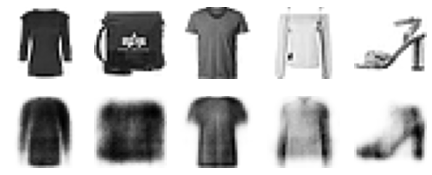

In [4]:
utils.reconstruct(simple_autoencoder, x_val[:5])

In [5]:
def plot_activations_hist(encoder, num_bins=10):
    x_val_codings = encoder(x_val).numpy()
    activation_means = x_val_codings.mean(axis=0)
    print(f"overall mean = {activation_means.mean():.4f}")
    bins = np.linspace(0, 1, num_bins + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(x_val_codings.ravel(), bins=bins, rwidth=0.8)
    plt.grid(True)
    plt.title("Activation")
    plt.subplot(1, 2, 2)
    plt.hist(activation_means, bins=bins, rwidth=0.8)
    plt.grid(True)
    plt.title("Neuron Mean Activation")
    plt.show()

overall mean = 0.3901


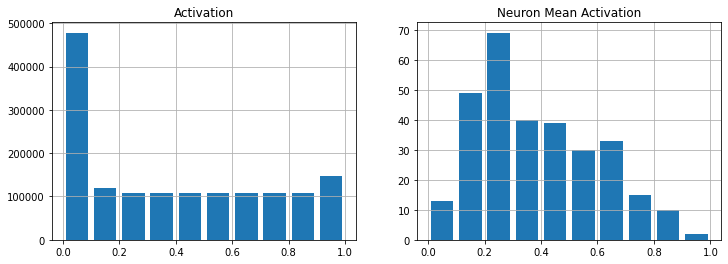

In [6]:
plot_activations_hist(simple_encoder)

## Sparse autoencoder with L1 regularization 

In [7]:
utils.reset_session()

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(300, activation='sigmoid'),
    keras.layers.ActivityRegularization(l1=1e-3)
], name='sparse_l1_encoder')
sparse_l1_encoder.summary()

sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[300]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
], name='sparse_l1_decoder')
sparse_l1_decoder.summary()

sparse_l1_autoencoder = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])

sparse_l1_autoencoder.compile(
    loss='binary_crossentropy', 
    optimizer=keras.optimizers.SGD(1.0),
    metrics=[utils.rounded_accuracy]
)

history = sparse_l1_autoencoder.fit(
    x_train, x_train, 
    epochs=10,
    validation_data=(x_val, x_val)
)

Model: "sparse_l1_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 300)               30300     
_________________________________________________________________
activity_regularization (Act (None, 300)               0         
Total params: 108,800
Trainable params: 108,800
Non-trainable params: 0
_________________________________________________________________
Model: "sparse_l1_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               30100     
________________

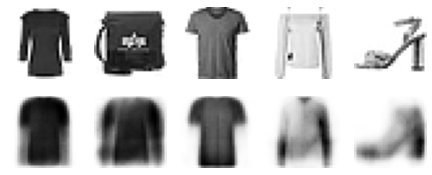

In [8]:
utils.reconstruct(sparse_l1_autoencoder, x_val[:5])

overall mean = 0.0201


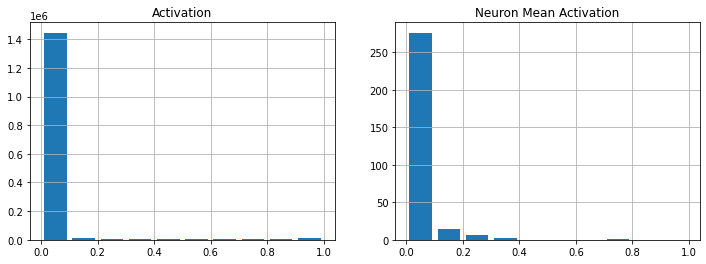

In [9]:
plot_activations_hist(sparse_l1_encoder)

## Sparse autoencoder with KL divergence regularization 

In [10]:
class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target

    def __call__(self, x):
        mean_activities = K.mean(x, axis=0)
        return self.weight * (
                keras.losses.kullback_leibler_divergence(self.target, mean_activities) +
                keras.losses.kullback_leibler_divergence(1. - self.target, 1. - mean_activities))


In [11]:
utils.reset_session()

sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(300, activation='sigmoid', 
                       activity_regularizer=KLDivergenceRegularizer(weight=0.05, target=0.1)),
], name='sparse_kl_encoder')
sparse_kl_encoder.summary()

sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[300]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
], name='sparse_kl_decoder')
sparse_kl_decoder.summary()

sparse_kl_autoencoder = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])

sparse_kl_autoencoder.compile(
    loss='binary_crossentropy', 
    optimizer=keras.optimizers.SGD(1.0),
    metrics=[utils.rounded_accuracy]
)

history = sparse_kl_autoencoder.fit(
    x_train, x_train, 
    epochs=10,
    validation_data=(x_val, x_val)
)

Model: "sparse_kl_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 300)               30300     
Total params: 108,800
Trainable params: 108,800
Non-trainable params: 0
_________________________________________________________________
Model: "sparse_kl_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               79184     
________________

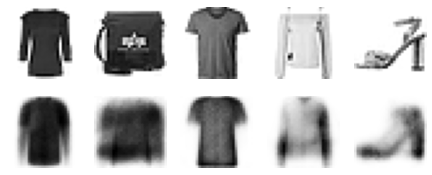

In [12]:
utils.reconstruct(sparse_kl_autoencoder, x_val[:5])

overall mean = 0.1056


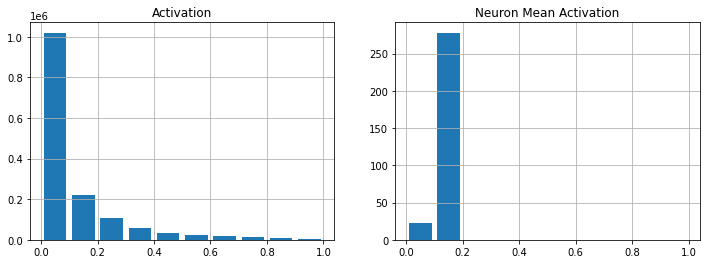

In [13]:
plot_activations_hist(sparse_kl_encoder)